# Solving single- and multi-objective constrained problems

In this notebook, we show two examples of how constrained problems can be solved in jMetalPy using single- and multi-objective genetic algorithms.

## Defining a constrained problem
Let start by considering the bi-objective problem known as Srinivas, which has the following formulation (see [DPA02](https://doi.org/10.1109/4235.996017)):
):

$$
f_1(\vec{x}) = (x_1 - 2)^2 + (x_2 - 1)^2 + 2 
$$
$$
f_2(\vec{x}) = 9x_1 - (x_2 - 1)^2
$$
$$
g_1(\vec{x}) = x^2_1 + x^2_2 \le 225
$$
$$
g_2(\vec{x}) = x_1 - 3x_2 \le -10
$$
$$x \in [-20, 20]
$$


The constraint hanlding mechanism included in jMetalPy is the one used by NSGA-II (see again [DPA02](https://doi.org/10.1109/4235.996017)), which is based on computing the overall constraint violation degree of a given solution. This degree is calculated by summing the degrees of violation of all constraints when their value is less than zero, so we have to re-formulate the constraints:

$$
g_1(\vec{x}) = 1.0 - (x_1 * x_1 + x_2 * x_2) / 225.0
$$
$$
g_2(\vec{x}) = (3.0 * x_2 - x_1) / 10.0 - 1.0
$$

We can implement problem Srinivas in two ways. The first one is by extending the ``FloatProblem`` abstract class (see [Srinivas](https://github.com/jMetal/jMetalPy/blob/main/jmetal/problem/multiobjective/constrained.py)) and the second one is by using the ``OnTheFlyFloatProblem()``class. We use the second approach:

In [1]:
from jmetal.core.problem import OnTheFlyFloatProblem

def f1(x: [float]):
        return 2.0 + (x[0] - 2.0) * (x[0] - 2.0) + (x[1] - 1.0) * (x[1] - 1.0)

def f2(x: [float]):
        return 9.0 * x[0] - (x[1] - 1.0) * (x[1] - 1.0)

def g1(x: [float]):
        return 1.0 - (x[0] * x[0] + x[1] * x[1]) / 225.0

def g2(x: [float]):
        return (3.0 * x[1] - x[0]) / 10.0 - 1.0

problem = (
        OnTheFlyFloatProblem()
        .set_name("Srinivas")
        .add_variable(-20.0, 20.0)
        .add_variable(-20.0, 20.0)
        .add_function(f1)
        .add_function(f2)
        .add_constraint(g1)
        .add_constraint(g2)
    )

In [2]:
problem

## Configuring NSGA-II 
The constraing handling mechanism of NSGA-II consists of first checking the overall constraint violation degree of the solutions to be compared; if both are feasible or have the same degree of violation, a dominance test is applied. These steps are carried out by the ``DominanceWithConstraintsComparator`` class. 

An example of NSGA-II configuration to solve the Srinivas problem is the following:

In [9]:
from jmetal.algorithm.multiobjective import NSGAII
from jmetal.operator import PolynomialMutation, SBXCrossover
from jmetal.util.comparator import DominanceWithConstraintsComparator
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import get_non_dominated_solutions

algorithm = NSGAII(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables(), distribution_index=20),
        crossover=SBXCrossover(probability=1.0, distribution_index=20),
        termination_criterion=StoppingByEvaluations(max_evaluations=25000),
        dominance_comparator=DominanceWithConstraintsComparator())

In [10]:
algorithm.run()

[2024-01-22 12:11:43,773] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-01-22 12:11:43,779] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-01-22 12:11:43,784] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-01-22 12:11:43,788] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2024-01-22 12:11:49,456] [jmetal.core.algorithm] [DEBUG] Finished!


In [11]:
front = get_non_dominated_solutions(algorithm.get_result())

In [19]:
import matplotlib.pyplot as plt

In [20]:
objectives = [solution.objectives for solution in front]

x = [_[0] for _ in objectives]
y = [_[1] for _ in objectives]

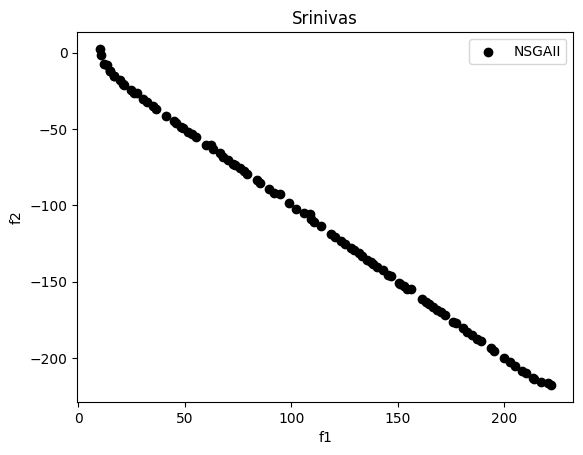

In [22]:
plt.scatter(x, y, color="black")

plt.xlabel("f1")
plt.ylabel("f2")
plt.title(problem.name())
plt.legend(["NSGAII"])